In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score,
                             roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
import warnings

In [77]:
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [78]:
#Loadin Dataset
dataset=pd.read_csv("kepler_train.csv")
#Loadin test dataset
test_dataset=pd.read_csv("kepler_test.csv")

In [79]:
#checking first 5 rows
dataset.head()

,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_period_log,koi_prad_log,koi_duration_log,depth_duration_ratio,planet_star_radius_ratio,insol_log,habitable_zone,total_fp_flags,target,target_name
0,1.189947,-0.040309,1.782828,-0.505903,-0.376061,-0.053256,-0.259448,0.259448,-0.420143,-0.428042,...,-0.966547,0.399701,-0.736977,-0.018886,-0.056395,0.755708,-0.269495,0.048234,1,CONFIRMED
1,-0.219580,-0.040309,-0.560907,-0.505903,-0.376061,-0.050893,-0.250004,0.250004,-0.440125,0.053279,...,-0.509153,-0.858531,-0.357307,-0.271441,-0.083068,0.280126,-0.269495,-0.155158,0,CANDIDATE
2,-0.219580,0.165507,-0.560907,1.976664,-0.376061,0.081046,1.087253,-1.087253,0.121374,1.371311,...,1.565323,-0.660178,1.592176,-0.271304,-0.080138,-1.550989,3.710642,0.251626,2,FALSE_POSITIVE
3,-0.302494,-0.040309,-0.560907,-0.505903,-0.376061,0.224456,2.569366,-2.569366,4.167312,0.579622,...,2.001147,-0.719384,1.139531,-0.271589,-0.081317,-1.660613,3.710642,-0.155158,0,CANDIDATE
4,-1.050955,-0.040309,-0.560907,1.976664,-0.376061,-0.047939,-0.255163,0.255163,-0.496274,-0.249912,...,-0.200952,-0.121775,-0.377493,-0.271121,-0.082848,1.143256,-0.269495,0.048234,2,FALSE_POSITIVE


In [80]:
#checking shape of dataset
print(f"Shape of dataset is {dataset.shape}")

Shape of dataset is (5520, 129)


In [81]:
dataset.columns

Index(['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1',
       ...
       'koi_period_log', 'koi_prad_log', 'koi_duration_log',
       'depth_duration_ratio', 'planet_star_radius_ratio', 'insol_log',
       'habitable_zone', 'total_fp_flags', 'target', 'target_name'],
      dtype='object', length=129)

In [82]:
#convert multi-class classification into binary-classification
dataset['target_name'] = dataset['target_name'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 0,
    'FALSE POSITIVE': 0
}).fillna(0)

test_dataset['target_name'] = test_dataset['target_name'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 0,
    'FALSE POSITIVE': 0
}).fillna(0)

In [83]:
# Check target distribution
print(f"\nTarget Distribution:")
print(dataset['target_name'].value_counts())



Target Distribution:
target_name
0.0    3874
1.0    1646
Name: count, dtype: int64


In [84]:
print(f"\nClass Balance:")
print(dataset['target_name'].value_counts(normalize=True))


Class Balance:
target_name
0.0    0.701812
1.0    0.298188
Name: proportion, dtype: float64


In [85]:
#Check for missing values
print(f"\nMissing Values:")
missing = dataset.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    miss_col=missing[missing > 0].index
else:
    print("No missing values! ✅")



Missing Values:
koi_eccen_err1      5520
koi_eccen_err2      5520
koi_longp           5520
koi_longp_err1      5520
koi_longp_err2      5520
koi_ingress         5520
koi_ingress_err1    5520
koi_ingress_err2    5520
koi_sma_err1        5520
koi_sma_err2        5520
koi_incl_err1       5520
koi_incl_err2       5520
koi_teq_err1        5520
koi_teq_err2        5520
koi_model_dof       5520
koi_model_chisq     5520
koi_sage            5520
koi_sage_err1       5520
koi_sage_err2       5520
dtype: int64


In [86]:
miss_col

Index(['koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1',
       'koi_longp_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2',
       'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 'koi_incl_err2',
       'koi_teq_err1', 'koi_teq_err2', 'koi_model_dof', 'koi_model_chisq',
       'koi_sage', 'koi_sage_err1', 'koi_sage_err2'],
      dtype='object')

In [87]:
# Check for infinite values
print(f"\nInfinite Values Check:")
inf_cols = []
for col in dataset.columns:
    if dataset[col].dtype in ['float64', 'int64']:
        if np.isinf(dataset[col]).any():
            inf_cols.append(col)
if inf_cols:
    print(f"Columns with infinite values: {inf_cols}")
else:
    print("No infinite values! ✅")


Infinite Values Check:
No infinite values! ✅


In [88]:
# Separate features and target
x_train = dataset.drop(list(miss_col) + ["target","target_name"], axis=1)
y_train = dataset['target_name']
x_test=test_dataset.drop(list(miss_col) + ["target","target_name"], axis=1)
y_test=test_dataset['target_name']

In [89]:
x_test.shape

(1841, 108)

In [90]:
x_train = x_train.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with median (robust to outliers)
if x_train.isnull().sum().sum() > 0:
    print("Filling missing values with median...")
    x_train = x_train.fillna(x_train.median())

# Remove constant features (zero variance)
constant_features = [col for col in x_train.columns if x_train[col].nunique() == 1]
if constant_features:
    print(f"Removing {len(constant_features)} constant features...")
    x_train = x_train.drop(columns=constant_features)

print(f"Final Feature Count: {x_train.shape[1]}")

Removing 3 constant features...
Final Feature Count: 105


In [91]:
x_train.shape

(5520, 105)

In [92]:
x_test = x_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with median (robust to outliers)
if x_test.isnull().sum().sum() > 0:
    print("Filling missing values with median...")
    x_test = x_test.fillna(x_test.median())

# Remove constant features (zero variance)
constant_features = [col for col in x_test.columns if x_test[col].nunique() == 1]
if constant_features:
    print(f"Removing {len(constant_features)} constant features...")
    x_test = x_test.drop(columns=constant_features)

print(f"Final Feature Count: {x_test.shape[1]}")

Removing 3 constant features...
Final Feature Count: 105


In [93]:
print("\n⚖️ Handling class imbalance with SMOTE...")

# Apply SMOTE to balance classes
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
x_train, y_train = smote.fit_resample(x_train, y_train)

print(f"Balanced training set: {x_train.shape}")
print(f"Balanced class distribution:\n{pd.Series(y_train).value_counts()}")



⚖️ Handling class imbalance with SMOTE...
Balanced training set: (7748, 105)
Balanced class distribution:
target_name
1.0    3874
0.0    3874
Name: count, dtype: int64


In [94]:
#Training multiple models
models = {}
results = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train and evaluate a model"""
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation F1
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring='f1', n_jobs=-1).mean()

    print(f"\n📊 {name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"CV F1 Score: {cv_f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'model': model,
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': roc,
        'cv_f1': cv_f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [95]:
#Model#1
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric='logloss' # Removed early_stopping_rounds
)

results['XGBoost'] = evaluate_model('XGBoost', xgb_model,
                                    x_train, y_train,
                                    x_test, y_test)


Training XGBoost...

📊 XGBoost Results:
Accuracy: 0.9555
F1 Score: 0.9260
ROC-AUC: 0.9917
CV F1 Score: 0.9645

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1292
         1.0       0.92      0.93      0.93       549

    accuracy                           0.96      1841
   macro avg       0.94      0.95      0.95      1841
weighted avg       0.96      0.96      0.96      1841



In [96]:
#Model#2
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    verbose=-1
)

results['LightGBM'] = evaluate_model('LightGBM', lgb_model,
                                     x_train, y_train,
                                     x_test, y_test)


Training LightGBM...

📊 LightGBM Results:
Accuracy: 0.9598
F1 Score: 0.9332
ROC-AUC: 0.9920
CV F1 Score: 0.9652

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1292
         1.0       0.92      0.94      0.93       549

    accuracy                           0.96      1841
   macro avg       0.95      0.95      0.95      1841
weighted avg       0.96      0.96      0.96      1841



In [97]:
#Model#3
catboost_model = CatBoostClassifier(
    iterations=500,
    depth=7,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_state=RANDOM_STATE,
    verbose=False
)

results['CatBoost'] = evaluate_model('CatBoost', catboost_model,
                                     x_train, y_train,
                                     x_test, y_test)


Training CatBoost...

📊 CatBoost Results:
Accuracy: 0.9582
F1 Score: 0.9317
ROC-AUC: 0.9914
CV F1 Score: 0.9632

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1292
         1.0       0.91      0.96      0.93       549

    accuracy                           0.96      1841
   macro avg       0.94      0.96      0.95      1841
weighted avg       0.96      0.96      0.96      1841



In [98]:
#Model#4
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

results['Random Forest'] = evaluate_model('Random Forest', rf_model,
                                          x_train, y_train,
                                          x_test, y_test)



Training Random Forest...

📊 Random Forest Results:
Accuracy: 0.9522
F1 Score: 0.9213
ROC-AUC: 0.9890
CV F1 Score: 0.9584

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1292
         1.0       0.91      0.94      0.92       549

    accuracy                           0.95      1841
   macro avg       0.94      0.95      0.94      1841
weighted avg       0.95      0.95      0.95      1841



In [99]:
print("\n" + "="*80)
print("🏆 MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'CV F1': [results[m]['cv_f1'] for m in results]
})

comparison_df = comparison_df.sort_values('F1 Score', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Select best model based on F1 score (important for imbalanced data)
best_model_name = comparison_df.iloc[0]['Model']
best_model_result = results[best_model_name]
best_model = best_model_result['model']

print(f"\n🌟 Best Model: {best_model_name}")
print(f"   Accuracy: {best_model_result['accuracy']:.4f}")
print(f"   F1 Score: {best_model_result['f1_score']:.4f}")
print(f"   ROC-AUC: {best_model_result['roc_auc']:.4f}")



🏆 MODEL COMPARISON

         Model  Accuracy  F1 Score  ROC-AUC    CV F1
     LightGBM  0.959804  0.933213 0.992029 0.965203
     CatBoost  0.958175  0.931677 0.991352 0.963175
      XGBoost  0.955459  0.925993 0.991724 0.964488
Random Forest  0.952200  0.921288 0.989037 0.958393

🌟 Best Model: LightGBM
   Accuracy: 0.9598
   F1 Score: 0.9332
   ROC-AUC: 0.9920



📈 Creating visualizations...


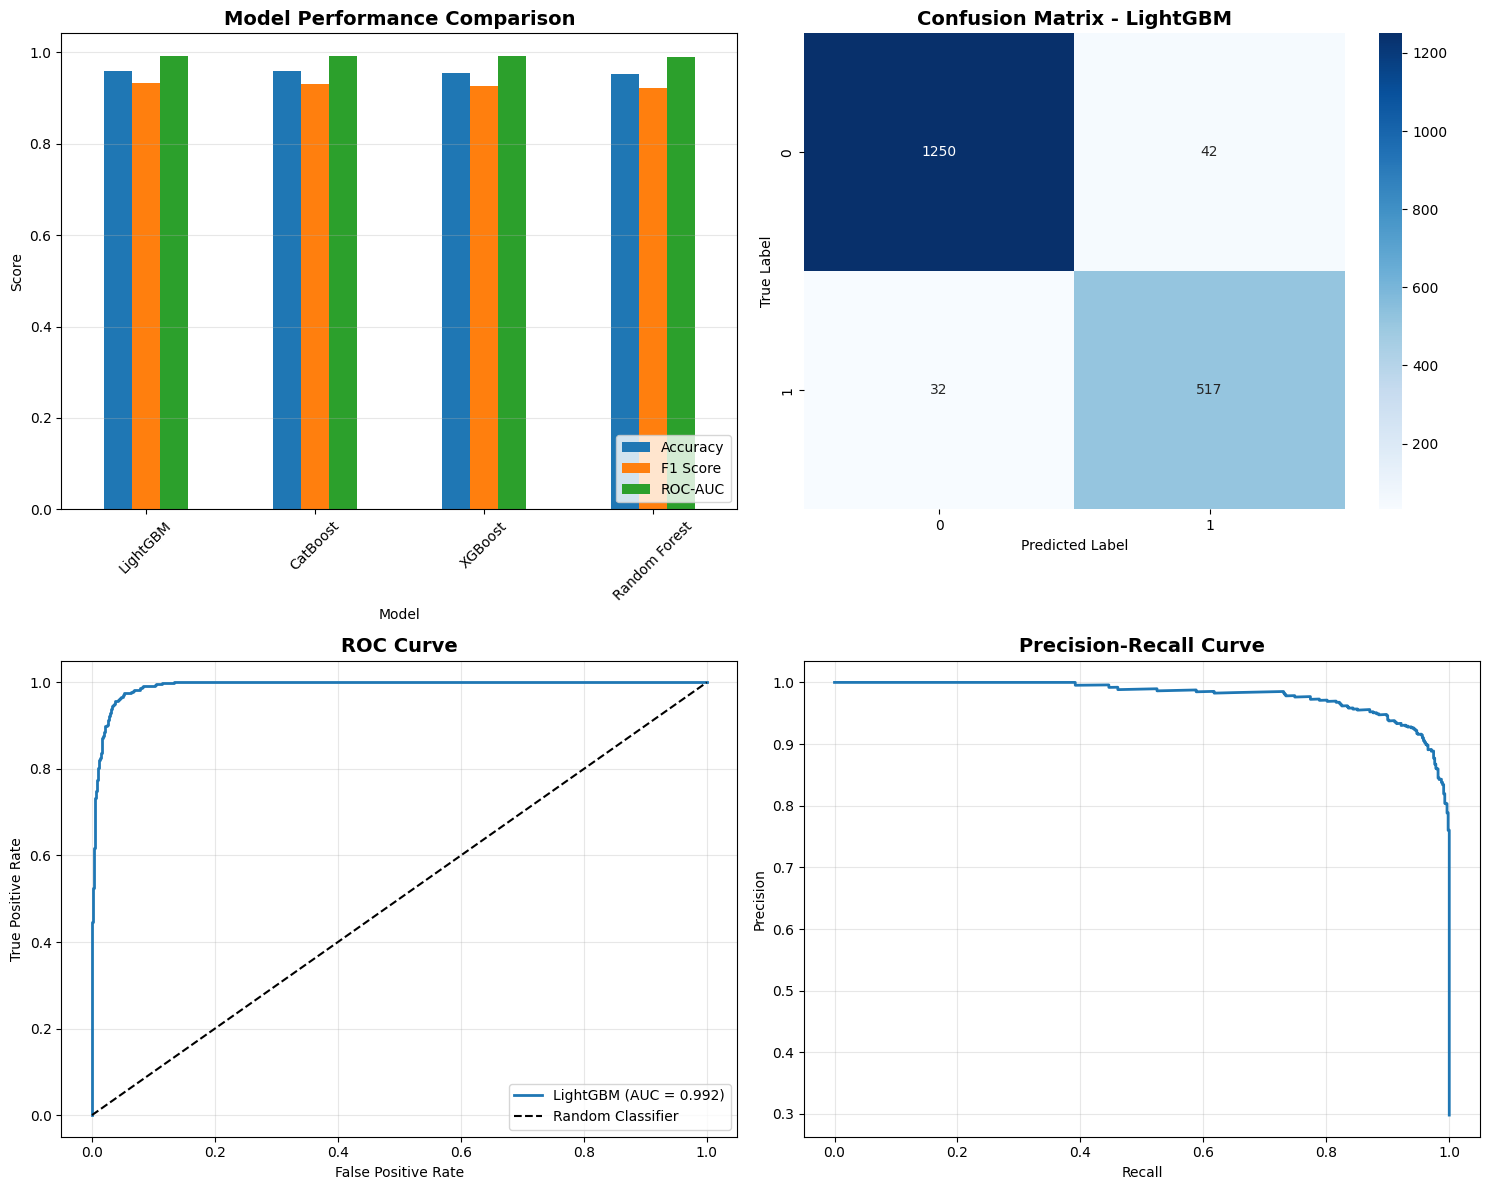

✅ Visualizations saved as 'exoplanet_model_results.png'


In [100]:
print("\n📈 Creating visualizations...")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Comparison Bar Plot
ax1 = axes[0, 0]
comparison_df.set_index('Model')[['Accuracy', 'F1 Score', 'ROC-AUC']].plot(
    kind='bar', ax=ax1, rot=45
)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# 2. Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, best_model_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
ax3 = axes[1, 0]
fpr, tpr, _ = roc_curve(y_test, best_model_result['y_pred_proba'])
ax3.plot(fpr, tpr, label=f'{best_model_name} (AUC = {best_model_result["roc_auc"]:.3f})', linewidth=2)
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Precision-Recall Curve
ax4 = axes[1, 1]
precision, recall, _ = precision_recall_curve(y_test, best_model_result['y_pred_proba'])
ax4.plot(recall, precision, linewidth=2)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('exoplanet_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved as 'exoplanet_model_results.png'")


📊 Top 20 Most Important Features:
         feature  importance
 koi_max_mult_ev         520
  koi_dicco_msky         396
       koi_score         386
koi_bin_oedp_sig         335
     koi_fwm_sra         324
       koi_count         301
   koi_dicco_mra         291
    koi_fwm_srao         282
   koi_srho_err1         281
        koi_smet         278
    koi_fwm_sdec         261
  koi_dicco_mdec         256
 koi_impact_err2         252
koi_max_sngle_ev         241
      koi_impact         239
  koi_dikco_mdec         226
    koi_duration         216
  koi_steff_err2         207
    koi_ror_err1         206
   koi_fwm_sdeco         206


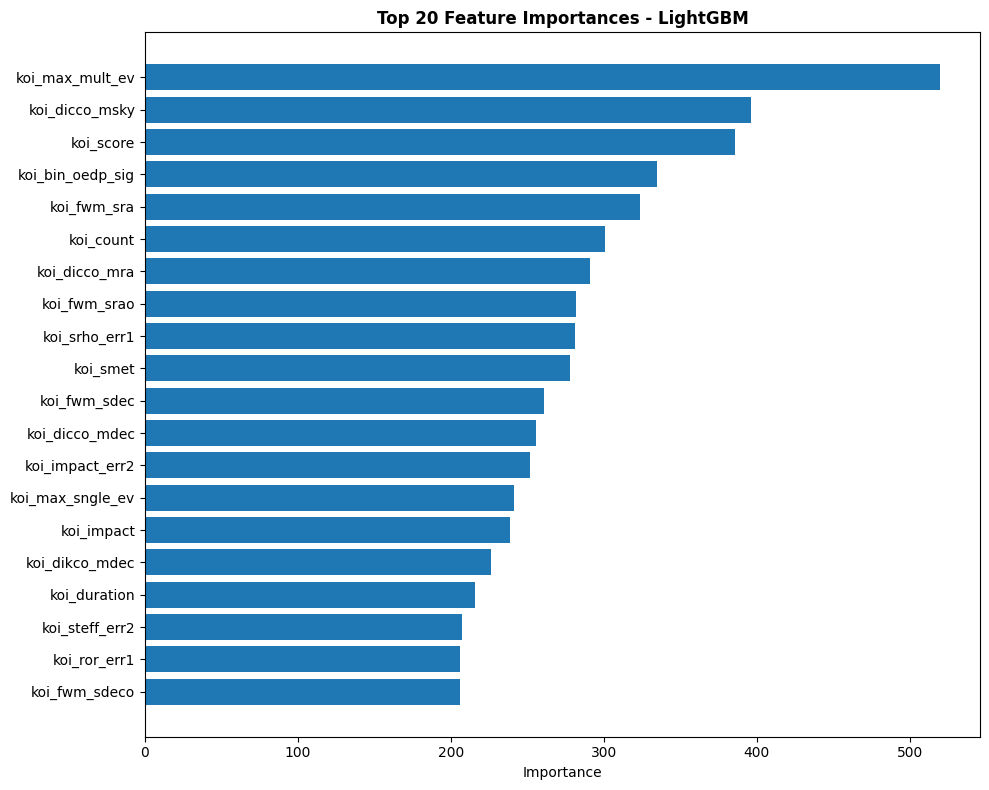

✅ Feature importance saved as 'feature_importance.png'


In [101]:
if hasattr(best_model, 'feature_importances_'):
    print("\n📊 Top 20 Most Important Features:")

    feature_importance = pd.DataFrame({
        'feature': x_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(20).to_string(index=False))

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Feature importance saved as 'feature_importance.png'")


In [102]:
import joblib
import pickle

# Save the best model
joblib.dump(best_model, f'best_exoplanet_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"✅ Best model saved as: best_exoplanet_model_{best_model_name.replace(' ', '_')}.pkl")


# Save predictions
predictions_df = pd.DataFrame({
    'true_label': y_test.values,
    'predicted_label': best_model_result['y_pred'],
    'prediction_probability': best_model_result['y_pred_proba']
})
predictions_df.to_csv('test_predictions.csv', index=False)
print("✅ Test predictions saved as: test_predictions.csv")

✅ Best model saved as: best_exoplanet_model_LightGBM.pkl
✅ Test predictions saved as: test_predictions.csv
